In [1]:
import numpy as np, cv2, glob, matplotlib.pyplot as plt

Article openCV camera calibration found on : https://aliyasineser.medium.com/opencv-camera-calibration-e9a48bdd1844

In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
imagesList = []

In [3]:
def getDownSampledImg(percent,img,seeImage=False):
    """
    Down sampling image (for faster further processing)
    usage of cv2.resize :
    https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d
    
    Image downsampling function
    
    :param percent: percent @which axis will be downsampled
    :param img: image input
    :param seeImage: if cv2.imshow to see result
    :type percent: int
    :type img: numpy.ndarray
    :type seeImage: bool
    :return: downsampled image
    :rtype: numpy.ndarray
    """
    width  = int(img.shape[1] * percent / 100)
    height = int(img.shape[0] * percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    if seeImage:
        print('Resized Dimensions : ',resized.shape)
        cv2.imshow("Resized image", resized)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return resized

In [4]:
def calibrate(dirpath,image_format,square_size,width=9,height=6,percent=100):
    """
    Calibrate the camera
    
    Take care : if chessboard has 10x7 white+black squares then width is 9, height 6
    Square size in meters
    
    returning values of this function :
    https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d
    
    function proposition from this blog article :
    https://aliyasineser.medium.com/opencv-camera-calibration-e9a48bdd1844
    
    :param dirpath: path of the chessboard images (about 20)
    :param square_size: edge size of one square
    :param width: number of intersection pts of squares in the long side
    :param height: " " " " " " " " short "
    :param percent: percent @ which image downsampled (speedup process)
    :type dirpath: string
    :type square_size: float
    :type width: int
    :type height: int
    :type percent: int
    :return: contains overall RMS, intrinsics matrix, distortion coeffs,
             rot vector of chessboard, translation vectors of chessboard
    :rtype: list
    """
    
    global imagesList
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
    objp = np.zeros((height*width, 3), np.float32)
    objp[:, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)
    objp = objp * square_size
    
    # store object pts and img pts from all images
    objpoints = []  # 3D point real world space
    imgpoints = []  # 2D points  image plane
    
    # if / at end of the path, discard
    if dirpath[-1:] == '/':
        dirpath = dirpath[:-1]
    images = glob.glob(dirpath+'/' + '*.' + image_format)
    
    for fname in images:
        # print(fname)
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if percent<100:
            grayMini = getDownSampledImg(percent,gray)
        else:
            grayMini = gray
        # print(grayMini.shape)
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(grayMini, (width, height), None)
        corners = corners*100/percent
        
        # If found, add object points, image points (after refining them)
        if ret:
            objpoints.append(objp)
            
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)
            
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (width, height), corners2, ret)
            cv2.imshow("Resized image", img)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            imagesList.append(img)
     
    rms,intrinsics, distorsion, rvecs, tvecs = cv2.calibrateCamera(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        None, None
    )
    print(rms)
    return [rms, intrinsics, distorsion, rvecs, tvecs] 

In [5]:
imagesList = []
a,b,c,d,e = calibrate(
    './images/photos/chessboard',
    'jpg',
    2.5e-2
)

1.3039598221537827


In [6]:
b # intrinsics

array([[903.23662829,   0.        , 620.57014994],
       [  0.        , 902.99032431, 301.1370533 ],
       [  0.        ,   0.        ,   1.        ]])

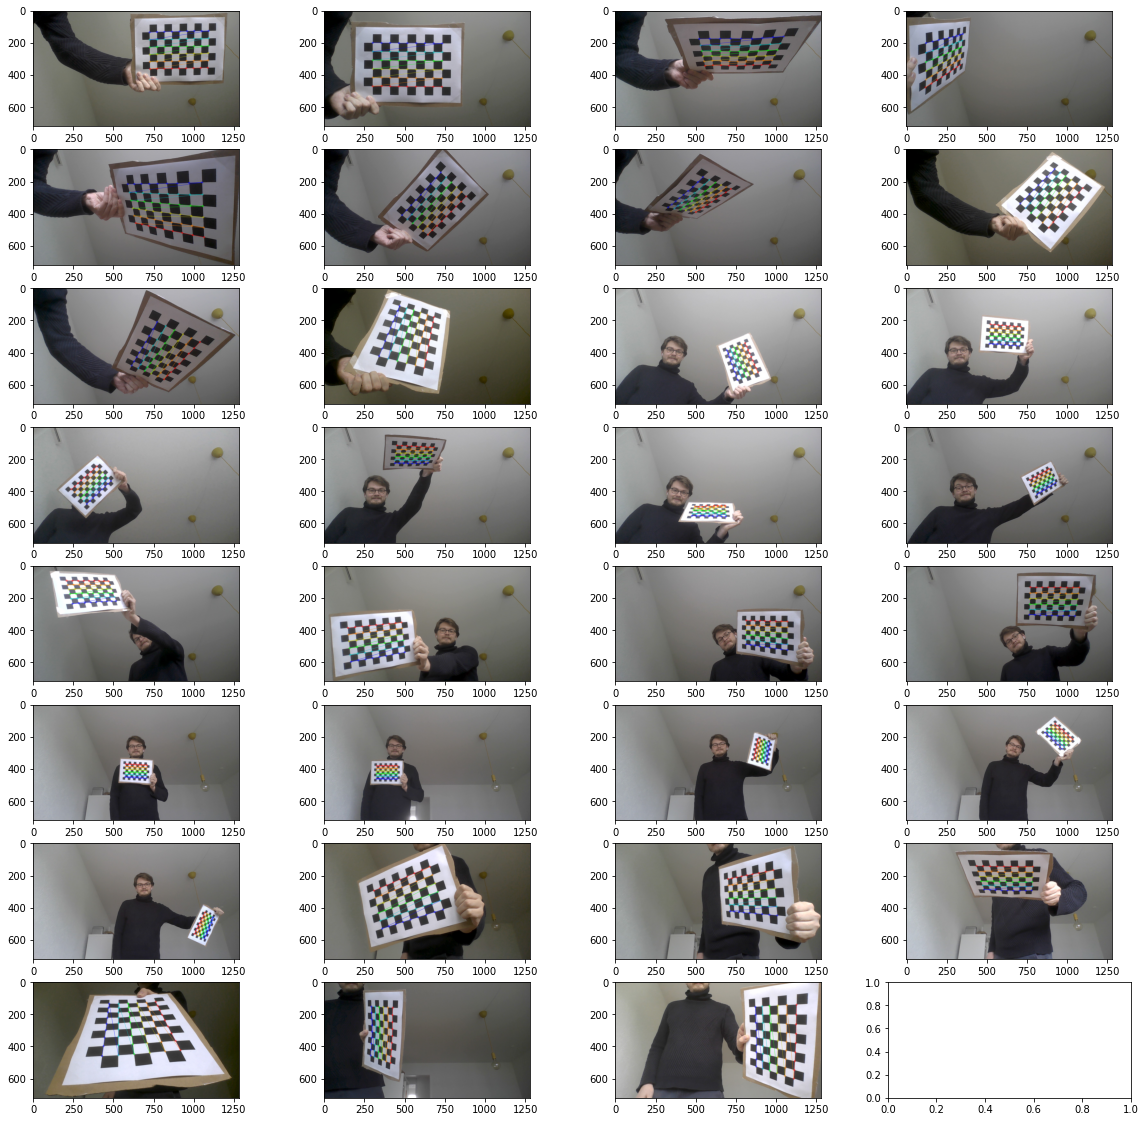

In [7]:
fig,ax = plt.subplots(8,4,figsize=(20,20))
for i in range(ax.size-1):
    ax[int(i/4),i%4].imshow(cv2.cvtColor(imagesList[i],cv2.COLOR_BGR2RGB))

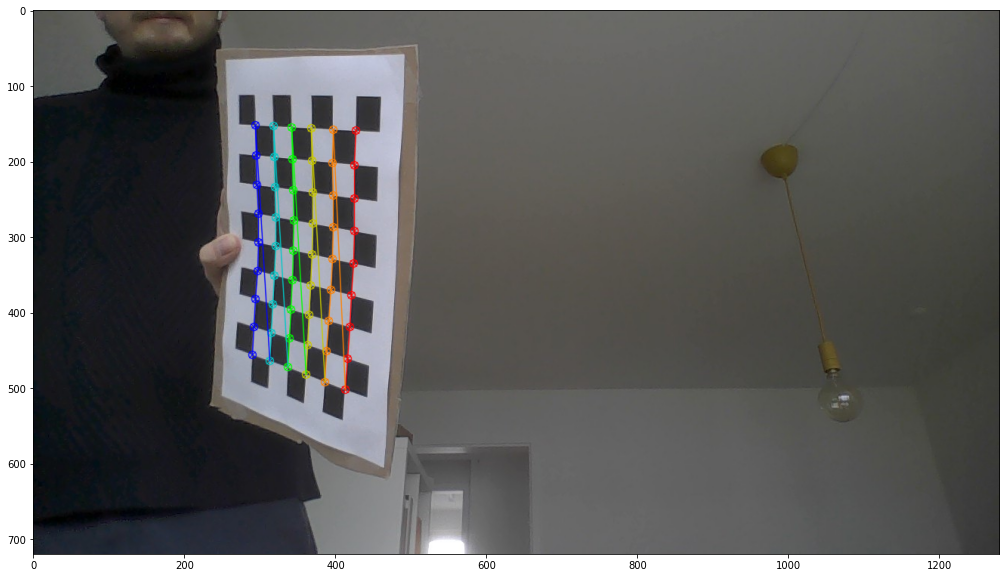

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(cv2.cvtColor(imagesList[29],cv2.COLOR_BGR2RGB))